In [6]:
%reset -f

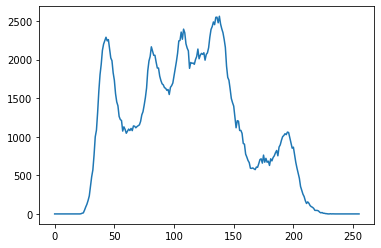

In [25]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

img_file = 'lena512color.tiff'

intensities = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
unique, counts = np.unique(intensities, return_counts=True)

height = np.shape(intensities)[0]
width = np.shape(intensities)[1]

u = unique.copy()
c = counts.copy()
for i in range(0,unique[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique[-1])
all_counts = np.append(c,z)
a = np.array(range(unique[-1]+1, 256))
var = np.append(u,a)

occurance_sum = sum(all_counts)
prbs = all_counts/occurance_sum
plt.plot(var, all_counts)

In [14]:
cells_num = 256

all_yijs = []
all_dijs = []

for i in range(0,cells_num-1):
    for j in range(i+1,cells_num):
# Strategy1: Eve knows the source statistics which is rare in image encrytion
#         possible_yij = (var[i]*prbs[i]+var[j]*prbs[j])\ 
#                        /(prbs[i]+prbs[j])

# Strategy2: Eve knows the reconstruction value of each cell
        possible_yij = (var[i]+var[j])/2
        #possibel_yij = random.choice([var[i],var[j]])
        
    
        all_yijs = np.append(all_yijs, possible_yij)
        
        possible_dij\
        = var[i]**2*prbs[i] + possible_yij**2*prbs[i] - possible_yij*2*var[i]*prbs[i]\
        + var[j]**2*prbs[j] + possible_yij**2*prbs[j] - possible_yij*2*var[j]*prbs[j]
        all_dijs = np.append(all_dijs, possible_dij)

# We implement the linear programming.
obj_coef = -all_dijs
all_length = int(cells_num * (cells_num-1) / 2)

A_eq = np.zeros([cells_num, all_length])
k = 0
for i in range(0, cells_num-1):
    for j in range(i+1,cells_num):
        A_eq[i,k]=1
        k+=1
k = 0
for j in range(1, cells_num):
    for i in range (j,cells_num):
        A_eq[i,k]=1
        k+=1

b_eq = np.ones([cells_num,])

result = linprog(obj_coef, A_eq=A_eq, b_eq=b_eq)
opt_xs = result.x
opt_pairs = np.round(result.x) # Pairs
opt_distortion = -result.fun # Value of the distortion

In [15]:
k = 0
xx = np.zeros([cells_num, cells_num])
for i in range(0,cells_num):
    for j in range(i+1,cells_num):
        xx[i,j] = opt_pairs[k]
        k +=1
        
lp_pairs_show = np.array(np.where(xx == 1))
print(lp_pairs_show)         
    
        
# xx = xx + np.transpose(xx)
# yy = np.where(xx)
# zz = np.append(yy[0],yy[1])
# pairs = np.reshape(zz,[2,cells_num])
# pairs = pairs[:,0:int(cells_num/2)]

print(opt_distortion)
print(opt_xs)
print(opt_pairs)
# print('\n', pairs)
'''The results does not seem correct, then integer linear programming must be used'''

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
   36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
   54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
   72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
   90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
  108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 125 163
  164 165]
 [124 127 126 128 130 131 129 132 133 134 135 138 140 141 144 139 137 143
  136 142 146 145 147 148 149 151 152 150 247 153 250 243 154 240 155 248
  244 246 241 235 234 156 157 158 159 160 161 216 162 225 217 223 209 228
  226 231 222 215 221 210 219 238 237 232 224 233 236 229 218 220 204 211
  205 227 203 213 214 207 230 212 251 242 252 254 255 253 249 239 245 208
  206 200 199 198 194 197 191 187 193 176 172 179 169 175 178 185 186 184
  180 192 189 182 183 171 1

'The results does not seem correct, then integer linear programming must be used'

In [17]:
dual_xx = xx + np.transpose(xx)

lp_enc_intens = np.zeros([height,width])
for i in range(0,height):
    for j in range(0,width):
        true_val = intensities[i][j]
        lp_pair_val = np.array(np.where(dual_xx[true_val]==1))
        lp_paired_vals = [true_val, lp_pair_val]
        lp_enc_intens[i][j] = random.choice(lp_paired_vals)

In [18]:
print(intensities)
cv2.imshow('orig_image',intensities)
cv2.waitKey(1000)
filename = 'gray.bmp'
cv2.imwrite(filename, lp_uint8)
cv2.waitKey(1000)

[[ 14  16  15 ... 101 105 104]
 [ 20  16  13 ...  99 103 102]
 [ 15  17  13 ... 101 100 102]
 ...
 [139 141 142 ...  77  78  79]
 [138 141 140 ...  74  77  79]
 [134 139 139 ...  75  75  79]]


-1

In [19]:
cv2.destroyAllWindows()

In [20]:
lp_uint8 = lp_enc_intens.astype(np.uint8)
cv2.imshow('lp_enc', lp_uint8)
filename = 'lp_enc.bmp'
cv2.imwrite(filename, lp_uint8)
cv2.waitKey(1000)

-1

In [21]:
cv2.destroyAllWindows()

In [199]:
from mip import Model, xsum, maximize, BINARY

p = all_dijs
w = A_eq
c = 1
I = range(np.shape(w)[1])

m = Model('knapsack')

x = [m.add_var(var_type=BINARY) for i in I]

m.objective = maximize(xsum(p[i] * x[i] for i in I))

for j in range (0,cells_num):
    m += xsum(w[j][i] * x[i] for i in I) <= c

opt_value = m.optimize()
        
        
# mip_xx = mip_xx + np.transpose(mip_xx)
# mip_yy = np.where(mip_xx)
# mip_zz = np.append(mip_yy[0],mip_yy[1])
# mip_pairs_show = np.reshape(mip_zz,[2,cells_num])
# mip_pairs_show = mip_pairs_show[:,0:int(cells_num/2)]

# print('\n', mip_pairs_show)
'''Do not run this cell, it takes time'''

'Do not run this cell, it takes time'

In [201]:
print(m.objective_value)
selected = [i for i in I if x[i].x >= 0.99]
# print('selected items: {}'.format(selected))

mip_pairs = []
for i in I:
    mip_pair = x[i].x
    mip_pairs = np.append(mip_pairs, mip_pair)
    
k = 0
mip_xx = np.zeros([cells_num, cells_num])
for i in range(0,cells_num):
    for j in range(i+1,cells_num):
        mip_xx[i,j] = mip_pairs[k]
        k +=1
        
mip_pairs_show = np.array(np.where(mip_xx == 1))
print(mip_pairs_show) 

4398.448774337769
[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
   36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
   54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
   72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
   90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
  108 109 110 111 112 113 114 115 117 118 119 120 121 122 123 124 125 126
  127 128]
 [154 156 155 153 157 158 159 152 144 151 145 150 143 147 148 160 142 149
  146 141 140 129 130 139 131 132 133 138 134 136 135 137 161 162 163 164
  165 172 177 205 207 208 209 211 210 212 253 255 250 254 252 251 249 248
  213 215 214 206 204 203 202 201 195 200 198 194 173 174 166 169 176 175
  171 167 193 197 168 178 199 196 179 180 170 192 181 182 191 183 187 190
  189 216 188 217 218 219 234 239 241 247 245 242 244 238 235 233 228 223
  222 186

In [172]:
print(mip_pairs_show-pairs)
munique, mcounts = np.unique(mip_pairs, return_counts=True)
print(munique, mcounts)
lpunique, lpcounts = np.unique(opt_pairs, return_counts=True)
print(lpunique, lpcounts)
'''The results of linear programming was correct, then integer linear programming must be used'''

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[0. 1.] [32512   128]
[0. 1.] [32512   128]


In [147]:
dual_mip_xx = mip_xx + np.transpose(mip_xx)

mip_enc_intens = np.zeros([height,width])
for i in range(0,height):
    for j in range(0,width):
        true_val = intensities[i][j]
        pair_val = np.array(np.where(dual_mip_xx[true_val]==1))
        paired_vals = [true_val, pair_val]
        mip_enc_intens[i][j] = random.choice(paired_vals)

NameError: name 'mip_xx' is not defined

In [22]:
nb_enc_intens = np.zeros([height,width])
for i in range(0,height):
    for j in range(0,width):
        true_val = intensities[i][j]
        if true_val <= 127:
            nb_pair_val = true_val + 128 
        else:
            nb_pair_val = true_val - 128
        nb_paired_vals = [true_val, nb_pair_val]
        nb_enc_intens[i][j] = random.choice(nb_paired_vals)

In [23]:
nb_uint8 = nb_enc_intens.astype(np.uint8)
cv2.imshow('nb_enc', nb_uint8)
filename = 'nb_enc.bmp'
cv2.imwrite(filename, nb_uint8)
cv2.waitKey(1000)

-1

In [24]:
cv2.destroyAllWindows()